In [1]:
pip install astropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 247 kB 4.2 MB/s 
     |████████████████████████████████| 4.5 MB 46.8 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
     |████████████████████████████████| 41 kB 181 kB/s 
     |████████████████████████████████| 832 kB 61.1 MB/s 
     |████████████████████████████████| 48 kB 3.8 MB/s 
     |████████████████████████████████| 4.0 MB 41.0 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=f74ed79e93f8c208c50f7e963c2adf21566ae9e9cd92e21ce846d0380d1bd488
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=51e61028cd19e743c74fc99c0b65052204a620a70f632dd8d63328da1b34d110
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995db

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.stats import BoxLeastSquares

import warnings
warnings.filterwarnings('ignore')


In [10]:
TIC = 'TIC 55652896' 

sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = [3,4,5]) 
 
lc = sector_data.download_all()


In [11]:
def plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model, results, period, duration, t0, mid_transit_t0, in_transit = [0], in_transit_notbinned = [0]):
  if len(in_transit) == 1:
    color1 = '#DC143C'
    color2 = 'darkorange'
    title = 'Initial BLS'
  else:
    color1 = 'deepskyblue'
    color2 = '#4682B4'
    title = 'Initial event removed'
    
  fig, axes = plt.subplots(3, 1, figsize=(5, 7))
  ax = axes[0]
  ax.axvline(period, alpha=0.4, lw=5, color = color1)
  
  for n in range(2, 15):
    ax.axvline(n*period, alpha=0.4, lw=2, linestyle="dashed", color = color2)
    ax.axvline(period / n, alpha=0.4, lw=2, linestyle="dashed", color = color2)

  ax.plot(results.period, results.power, "k", lw=0.5, label = 'P = %.3f T0 = %.3f' % (period,mid_transit_t0))
  ax.set_title(title)
  ax.set_xlim(results.period.min(), results.period.max())
  ax.set_xlabel("period (days)")
  ax.set_ylabel("log likelihood")
  ax.legend(fontsize = 10, loc = 1)

  ax = axes[1]

  if len(in_transit) == 1: 
        ax.plot(alltime, allflux, marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(alltimebinned, allfluxbinned, marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')
  else: 
        ax.plot(alltime[~in_transit_notbinned], allflux[~in_transit_notbinned], marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(alltimebinned[~in_transit], allfluxbinned[~in_transit], marker ="o", alpha = 0.6, color = 'black',  MarkerFaceColor = 'none', ms=3, lw = 0)

  x = np.linspace(alltimebinned.min(), alltimebinned.max(), 3*len(alltimebinned))
  f = model.model(x, period, duration, t0)
  ax.plot(x, f, lw=2, color = color1)
  ax.set_xlim(alltimebinned.min(), alltimebinned.max())
  ax.set_xlabel("time (days)")
  ax.set_ylabel("de-trended flux (ppt)");

  ax = axes[2]
  
  if len(in_transit) == 1:
        x_binned = (alltimebinned - t0 + 0.5*period) % period - 0.5*period
        x = (alltime - t0 + 0.5*period) % period - 0.5*period
  else: 
        x_binned = (alltimebinned[~in_transit] - t0 + 0.5*period) % period - 0.5*period
        x = (alltime[~in_transit_notbinned] - t0 + 0.5*period) % period - 0.5*period

  m_binned = np.abs(x_binned) < 0.5
  m = np.abs(x) < 0.5

  
  if len(in_transit) == 1:  # for the initial run
        ax.plot(x[m], allflux[m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(x_binned[m_binned], allfluxbinned[m_binned], marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')

  else: # for the second run (once the first 'event' has been removed)
        ax.plot(x[m], allflux[~in_transit_notbinned][m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(x_binned[m_binned], allfluxbinned[~in_transit][m_binned], marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')

  x = np.linspace(-0.5, 0.5, 1000)
  f = model.model(x + t0, period, duration, t0)
  ax.plot(x, f, lw=2, color = color1)
  ax.set_xlim(-0.5, 0.5)
  ax.set_xlabel("time since transit (days)")
  ax.set_ylabel("de-trended flux (ppt)");
  plt.tight_layout()

  plt.show()



In [12]:
def data_bls(lc):
   

    try:
        lc = lc.normalize()
    except:
        lc = lc.stitch()
        
    alltime = lc.time.value
    allflux = lc.flux.value
    
    lc_bin = lc.bin(15/60/24)
    alltimebinned = lc_bin.time.value
    allfluxbinned = lc_bin.flux.value
        
  
    mask_binned = np.isfinite(alltimebinned) * np.isfinite(allfluxbinned)
    mask = np.isfinite(alltime) * np.isfinite(allflux)

    alltimebinned = np.array(alltimebinned)[mask_binned]
    allfluxbinned = np.array(allfluxbinned)[mask_binned]
    alltime = np.array(alltime)[mask]
    allflux = np.array(allflux)[mask]

   

    mask_binned = np.isfinite(alltimebinned) * np.isfinite(allfluxbinned)
    alltimebinned = np.array(alltimebinned)[mask_binned]
    allfluxbinned = np.array(allfluxbinned)[mask_binned]
    
    durations = np.linspace(0.05, 0.5, 15)
    periods = np.arange(0.7, (np.nanmax(alltimebinned) - np.nanmin(alltimebinned)), 0.01)
    
    model = BoxLeastSquares(alltimebinned, allfluxbinned)
    results = model.power(periods, durations)

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    mid_transit_t0 = model.compute_stats(period, duration, t0)['transit_times'][0]

   

    plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model, results, period, duration, t0, mid_transit_t0)

    stats_period = period
    stats_t0 = mid_transit_t0
    stats_depth = model.compute_stats(period, duration, t0)['depth']
    stats_depth_phased = model.compute_stats(period, duration, t0)['depth_phased']
    stats_depth_half = model.compute_stats(period, duration, t0)['depth_half']
    stats_depth_odd = model.compute_stats(period, duration, t0)['depth_odd']
    stats_depth_even = model.compute_stats(period, duration, t0)['depth_even']

    if (1*duration) >= period: 
        return [stats_period, stats_t0, stats_depth, stats_depth_phased, stats_depth_half, stats_depth_odd, stats_depth_even], [-999]

    
    in_transit = model.transit_mask(alltimebinned, period, 2*duration, t0)
    in_transit_notbinned = model.transit_mask(alltime, period, 2*duration, t0)
    
    
    model2 = BoxLeastSquares(alltimebinned[~in_transit], allfluxbinned[~in_transit])
    results2 = model2.power(periods, durations)

    
    index = np.argmax(results2.power)
    period2 = results2.period[index]
    t02 = results2.transit_time[index]
    duration2 = results2.duration[index]
    mid_transit_t02 = model.compute_stats(period2, duration2, t02)['transit_times'][0]
    
    
    plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model2, results2,period2,duration2,t02, mid_transit_t02, in_transit = in_transit, in_transit_notbinned = in_transit_notbinned)
    
    stats2_period = period2
    stats2_t0 = mid_transit_t02
    stats2_depth = model2.compute_stats(period2, duration2, t0)['depth']
    stats2_depth_phased = model2.compute_stats(period2, duration2, t0)['depth_phased']
    stats2_depth_half = model2.compute_stats(period2, duration2, t0)['depth_half']
    stats2_depth_odd = model2.compute_stats(period2, duration2, t0)['depth_odd']
    stats2_depth_even = model2.compute_stats(period2, duration2, t0)['depth_even']
        
    df = pd.DataFrame({"Period (days)": [stats_period,stats2_period], "T0 (TBJD)":[stats_t0,stats2_t0], "Transit depth (ppm)":[stats_depth[0],stats2_depth[0]], "Odd depth (ppm)": [stats_depth_odd[0],stats2_depth_odd[0]], "Even depth (ppm)":[stats_depth_even[0],stats2_depth_even[0]]})
    return df



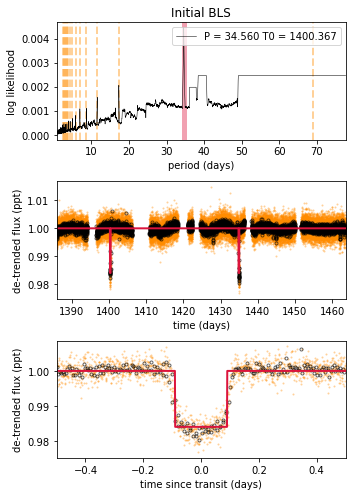

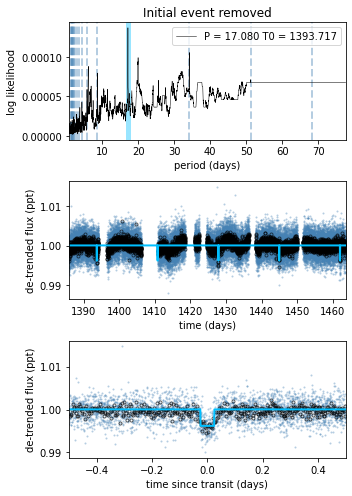

,Period (days),T0 (TBJD),Transit depth (ppm),Odd depth (ppm),Even depth (ppm)
0,34.56,1400.366919,0.015944,0.016562,0.015290
1,17.08,1393.716919,-0.000226,-0.001160,0.000522


In [14]:
df = data_bls(lc)

df

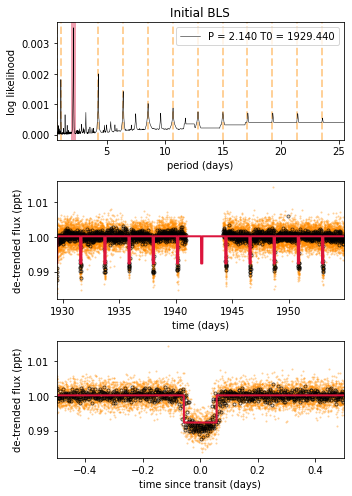

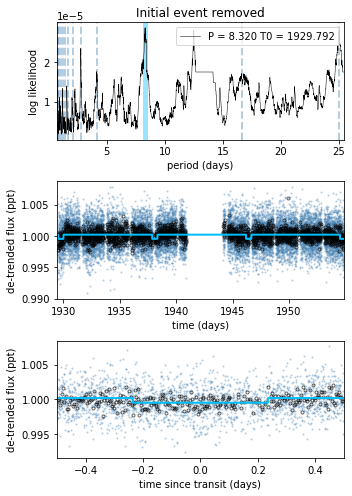

,Period (days),T0 (TBJD),Transit depth (ppm),Odd depth (ppm),Even depth (ppm)
0,2.14,1929.440039,0.007799,0.007891,0.007729
1,8.32,1929.792122,-0.000175,-0.000370,-0.000077


In [15]:
TIC = 'TIC 284475976'
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 23)
lc = sector_data.download()
df = data_bls(lc)
df

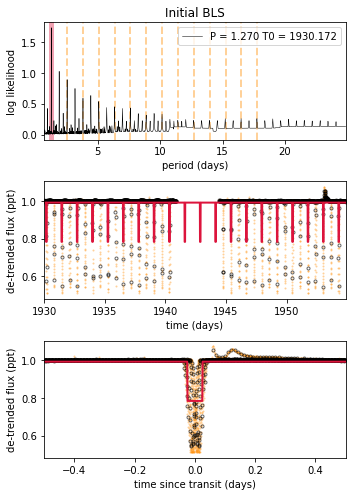

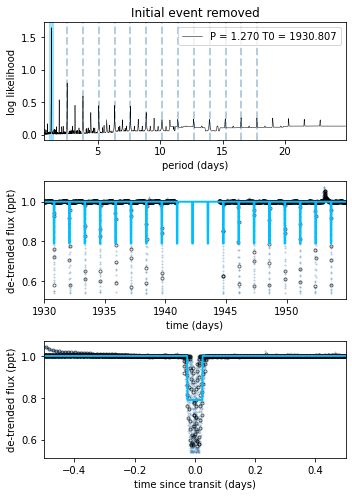

ValueError: ignored

In [21]:
TIC = 'TIC 199574208'
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 23)
lc = sector_data.download()
df = data_bls(lc)
df